In [86]:
import numpy as np
import torch
import ternary
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import os
import pandas as pd
from ternary.helpers import project_point

from ensemblecalibration.cal_estimates.kde_ece import ece_kde_obj, get_bandwidth
from ensemblecalibration.cal_estimates.skce import skce_obj
from ensemblecalibration.cal_estimates.brier import brier_obj
from ensemblecalibration.cal_estimates.mmd_kce import mmd_kce_obj

from ensemblecalibration.utils.helpers import multinomial_label_sampling, calculate_pbar   

# Visualization of Calibration Error Estimators

#### 1. Experiment:

As a first experiment, we ananlyse the estimators of different calibration errors. For ease of visualization,
we use the caseof $K=3$ predictors, and set 
$$\mathbb{P}(Y=k|X=x)= \begin{cases} \frac{1}{10}, k =1 \\
\frac{1}{10}, k=2 \\
\frac{8}{10}, k=3
\end{cases} \quad \forall x \in \mathcal{X}.$$
We then sample $N=1000$ labels from the defined distribution and for each point $p = (p_1, p_2, p_3)$,
we assume to have a constant predictor $f$ with $$f(x) \equiv p \quad \forall  x \in \mathcal{X}.$$ We then evaluate the calibration error based on the predicitons of $f$ and the labels $y_i$.

In [2]:
def miscalibration_estimate(p_probs, n_samples=1000, p_true = np.array([1/10, 1/10, 8/10]),
                             cal_estimate = "L2"):
    # Sample from the categorical distribution induced by the probability vector `p`
    if cal_estimate == "L2":
        params = {"p": 2, "bw": 0.1}
        miscal_obj = ece_kde_obj
    elif cal_estimate == "SKCE":
        params = {"bw": 0.01}
        miscal_obj = skce_obj
    elif cal_estimate == "Brier":
        params = {}
        miscal_obj = brier_obj
    elif cal_estimate == "MMD":
        params = {"bw": 0.001}
        miscal_obj = mmd_kce_obj
    else:
        raise ValueError("Invalid calibration estimate")
    p_true = np.tile(p_true, (n_samples, 1))
    y_labels = multinomial_label_sampling(p_true)
    p_probs = np.tile(p_probs, (n_samples, 1))
    miscalibration = miscal_obj(p_probs, y_labels, params)
    return miscalibration

In [3]:

# Create a grid over the 3-simplex
scale = 40  # Resolution of the grid (higher value gives finer grid)
heatmap_data_brier = {}
heatmap_data_l2 = {}
heatmap_data_skce = {}
heatmap_data_mmd = {}

# Loop over all points in the simplex (each point represents a probability distribution)
for i in range(scale + 1):



    
    for j in range(scale + 1 - i):
        k = scale - i - j
        # Convert grid indices to a probability distribution
        p = np.array([i, j, k]) / scale
        # Evaluate the miscalibration function at this point
        heatmap_data_brier[(i, j)] = miscalibration_estimate(p, cal_estimate="Brier")
        heatmap_data_l2[(i, j)] = miscalibration_estimate(p, cal_estimate="L2")
        heatmap_data_skce[(i, j)] = miscalibration_estimate(p, cal_estimate="SKCE")
        heatmap_data_mmd[(i, j)] = miscalibration_estimate(p, cal_estimate="MMD")


/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_29645/502639362.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_heatmap_data = {k: np.log(v) for k, v in data.items()}
/Users/mirajuergens/opt/miniconda3/envs/calibration_2/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


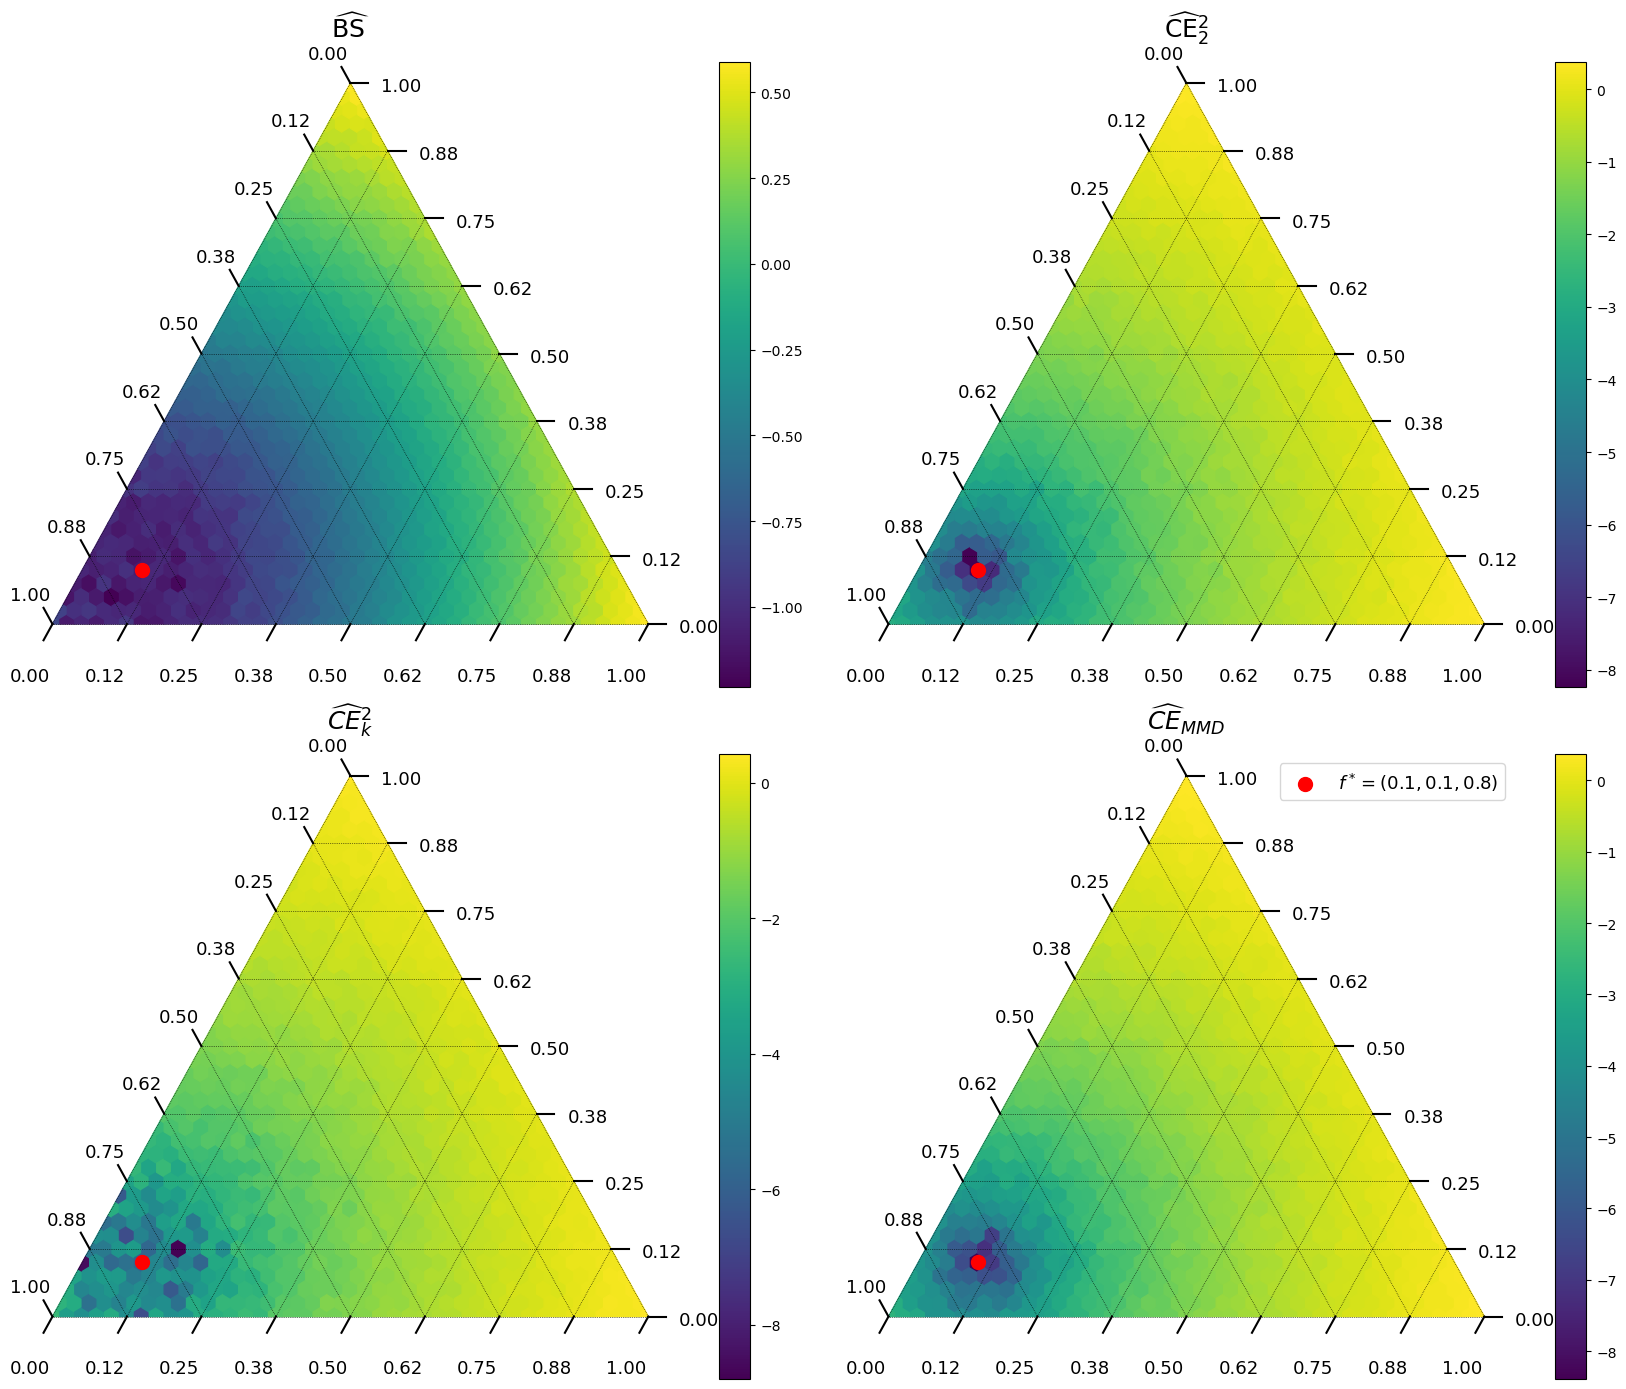

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(17, 14))
ax = ax.ravel()

for i, (data, title) in enumerate(
    zip(
        [heatmap_data_brier, heatmap_data_l2, heatmap_data_skce, heatmap_data_mmd],
        [r"$\widehat{\text{BS}}$", r"$\widehat{\text{CE}}_2^2$", r"$\widehat{CE}_k^2$", r"$\widehat{CE}_{MMD}$"],
    )
):
    ax[i].set_title(title, fontsize=18, pad=18)
    tax = ternary.TernaryAxesSubplot(ax=ax[i], scale=scale)
    tax.gridlines(multiple=5, color="black")

    #eps = 1e-10
    log_heatmap_data = {k: np.log(v) for k, v in data.items()}
    tax.heatmap(log_heatmap_data, scale=scale, style="hexagonal", cmap="viridis", colorbar=True)
    # change size of ticks of colorbar

    tick_multiple = 5  # Spacing between ticks in grid units
    tick_values = np.arange(0, scale+1, tick_multiple)  # Tick positions
    tick_labels = [f"{i/scale:.1f}" for i in tick_values]  # Normalized tick labels

    point = (1/10 * scale, 1/10 * scale, 8/10 * scale)

    # Plot the point in the simplex with a large marker size
    tax.scatter([point], marker='o', color='red', s=100, label="$f^* = (0.1, 0.1, 0.8)$")



    tax.set_axis_limits({'b': [0, 1], 'l': [0, 1], 'r': [0, 1]})
    tax.get_ticks_from_axis_limits(multiple=tick_multiple)
    tax.set_custom_ticks(tick_formats="%.2f", offset=0.03, fontsize=13)
    # Set ticks on the 'left', 'bottom', and 'right' axes with normalized labels
    # tax.ticks(
    #     axis='lbr',  # 'l' for left, 'b' for bottom, 'r' for right axis
    #     multiple=tick_multiple,  # Normalize tick values by dividing by scale
    #     offset=0.02,
    #     linewidth=1
    # )
    # Set ticks and titles
    #tax.ticks(axis='lbr', multiple=5)
    tax.clear_matplotlib_ticks()
    

    tax.get_axes().axis('off')
plt.legend(fontsize=13)


# Show the plot
plt.tight_layout()

plt.savefig("../figures/heatmap_cal_estimates.png", dpi=400)


    

### 2. Experiment


In [14]:
# we sample predictions from 3 ensemble members from a Dircihlet distribuiton, defiend by the following parameters
params_1 = np.array([1, 1, 10])
params_2 = np.array([1,10,1])
params_3 = np.array([10,1,1])

# we set the "true", i.e. calibrated convex combination to [0.1,0.1,0.8]
lambda_true = np.array([0.1, 0.1, 0.8])

# we sample 1000 predictions from each ensemble member
n_samples = 2000
preds_1 = np.random.dirichlet(params_1, n_samples)
preds_2 = np.random.dirichlet(params_2, n_samples)
preds_3 = np.random.dirichlet(params_3, n_samples)

# we compute the convex combination of the predictions
# first combine predictions in 1 tensor
preds = np.stack([preds_1, preds_2, preds_3], axis=2)

p_bar = calculate_pbar(lambda_true, preds, n_dims=1)

# sample labels according to the categorical distribution inudced by p_bar
y_labels = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)


In [15]:
bw_ece_kde = get_bandwidth(torch.from_numpy(p_bar))
bw_ece_kde

tensor(1.0000e-05)

In [16]:
def miscalibration_lambda(
    lambda_prop: np.ndarray,
    preds: np.ndarray = preds,
    lambda_true: np.ndarray = lambda_true,
    cal_estimate="L2",
):
    # calculate the convex combination of the true underlying distribution
    p_bar_true = calculate_pbar(lambda_true, preds, n_dims=1)
    # sample the labels according to this distribution
    y_labels = multinomial_label_sampling(p_bar_true)

    if cal_estimate == "L2":
        params = {"p": 2, "bw": 0.0001}
        miscal_obj = ece_kde_obj
    elif cal_estimate == "SKCE":
        params = {"bw": 0.001}
        miscal_obj = skce_obj
    elif cal_estimate == "Brier":
        params = {}
        miscal_obj = brier_obj
    elif cal_estimate == "MMD":
        params = {"bw": 0.001}
        miscal_obj = mmd_kce_obj
    else:
        raise ValueError("Invalid calibration estimate")
    # calculate the convex combination of the proposed weight
    p_bar = calculate_pbar(lambda_prop, preds, n_dims=1)
    miscalibration = miscal_obj(p_bar, y_labels, params)
    return miscalibration

In [17]:
miscalibration_lambda(np.array([0.1, 0.05, 0.85]), cal_estimate="L2")

tensor(0.0221)

In [18]:
torch.diag(torch.finfo(torch.float).min * torch.ones(len(preds)))
torch.finfo(torch.float).min

-3.4028234663852886e+38

In [19]:
# Create a grid over the 3-simplex
scale = 40  # Resolution of the grid (higher value gives finer grid)
heatmap_data_brier_lambda = {}
heatmap_data_l2_lambda = {}
heatmap_data_skce_lambda = {}
heatmap_data_mmd_lambda = {}

# Loop over all points in the simplex (each point represents a probability distribution)
for i in range(scale + 1):
    for j in range(scale + 1 - i):
        k = scale - i - j
        # Convert grid indices to a probability distribution
        lambda_prop = np.array([i, j, k]) / scale
        # Evaluate the miscalibration function at this point
        heatmap_data_brier_lambda[(i, j)] = miscalibration_lambda(lambda_prop, cal_estimate="Brier")
        heatmap_data_l2_lambda[(i, j)] = miscalibration_lambda(lambda_prop, cal_estimate="L2")
        heatmap_data_skce_lambda[(i, j)] = miscalibration_lambda(lambda_prop, cal_estimate="SKCE")
        heatmap_data_mmd_lambda[(i, j)] = miscalibration_lambda(lambda_prop, cal_estimate="MMD")

/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_29645/3437045377.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_heatmap_data = {k: np.log(v) for k, v in data.items()}


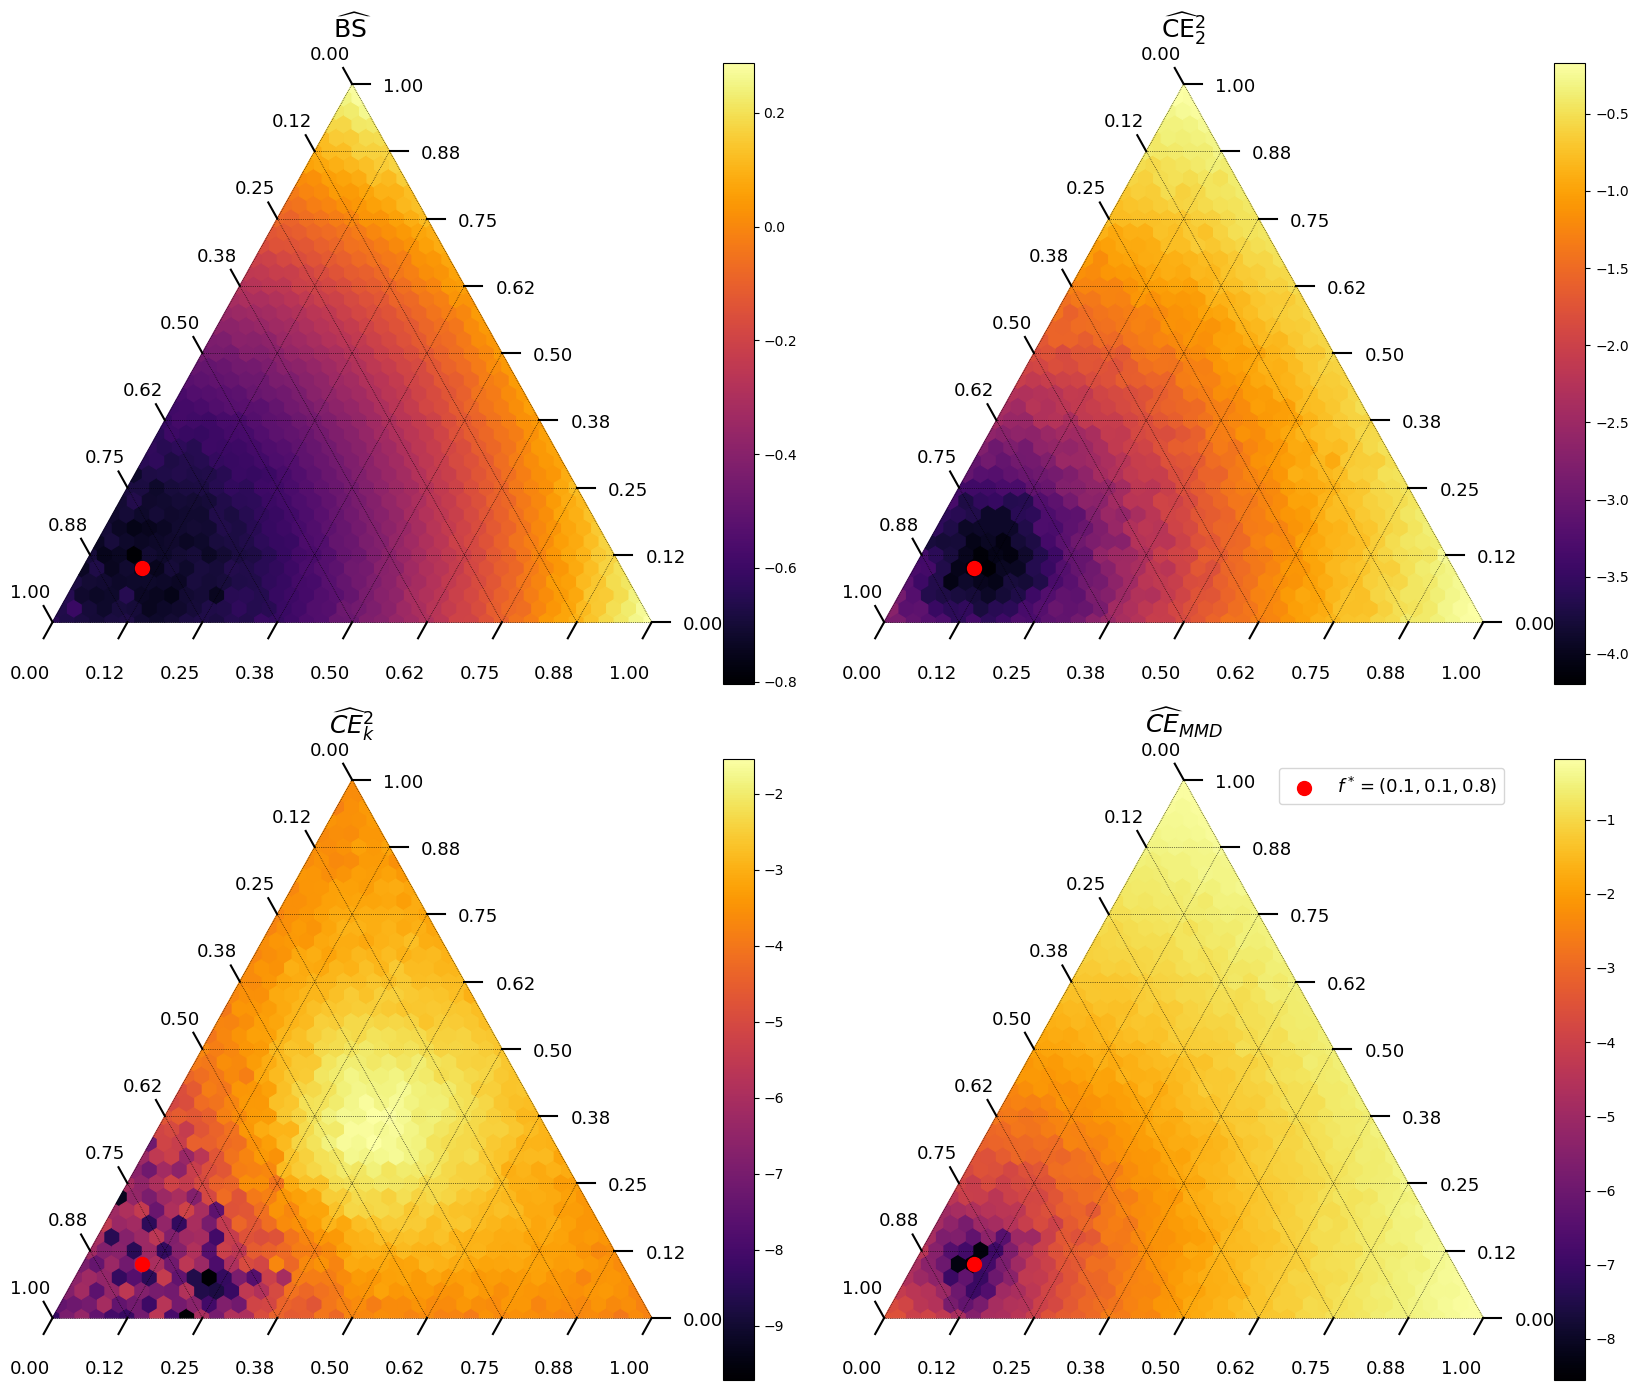

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(17, 14))
ax = ax.ravel()

for i, (data, title) in enumerate(
    zip(
        [heatmap_data_brier_lambda, heatmap_data_l2_lambda, heatmap_data_skce_lambda,
          heatmap_data_mmd_lambda],
        [r"$\widehat{\text{BS}}$", r"$\widehat{\text{CE}}_2^2$", r"$\widehat{CE}_k^2$", r"$\widehat{CE}_{MMD}$"],
    )
):
    ax[i].set_title(title, fontsize=18, pad=18)
    tax = ternary.TernaryAxesSubplot(ax=ax[i], scale=scale)
    tax.gridlines(multiple=5, color="black")

    #eps = 1e-10
    log_heatmap_data = {k: np.log(v) for k, v in data.items()}
    #use different cmap 
    cmap = "inferno"
    tax.heatmap(log_heatmap_data, scale=scale, style="hexagonal", cmap=cmap, colorbar=True)
    # change size of ticks of colorbar

    tick_multiple = 5  # Spacing between ticks in grid units
    tick_values = np.arange(0, scale+1, tick_multiple)  # Tick positions
    tick_labels = [f"{i/scale:.1f}" for i in tick_values]  # Normalized tick labels

    point = (1/10 * scale, 1/10 * scale, 8/10 * scale)

    # Plot the point in the simplex with a large marker size
    tax.scatter([point], marker='o', color='red', s=100, label="$f^* = (0.1, 0.1, 0.8)$")



    tax.set_axis_limits({'b': [0, 1], 'l': [0, 1], 'r': [0, 1]})
    tax.get_ticks_from_axis_limits(multiple=tick_multiple)
    tax.set_custom_ticks(tick_formats="%.2f", offset=0.03, fontsize=13)
    # Set ticks on the 'left', 'bottom', and 'right' axes with normalized labels
    # tax.ticks(
    #     axis='lbr',  # 'l' for left, 'b' for bottom, 'r' for right axis
    #     multiple=tick_multiple,  # Normalize tick values by dividing by scale
    #     offset=0.02,
    #     linewidth=1
    # )
    # Set ticks and titles
    #tax.ticks(axis='lbr', multiple=5)
    tax.clear_matplotlib_ticks()
    

    tax.get_axes().axis('off')
plt.legend(fontsize=13)


# Show the plot
plt.tight_layout()

plt.savefig("../figures/heatmap_cal_estimates_lambda.png", dpi=400)


## Analysis of the distribution of estimators under the null hypothesis

In the following, we want to look at the distribution of the calibration estimators under the null hypothesis.
That is, for a fixed sample size $N$, a number of classes $K$, we define a probabilistic predictor $$g_{H_0}: \mathcal{X} \rightarrow \Delta_K$$,
and for a given number of $d \in \mathbb{N}$, we sample labels $\{y_{1}^d, \dots, y_n^d \}$ from its predicted
probability distribution.

In [4]:
N = 4000
K = 3
D = 500
# sample N predictions from K dimensional Dirichlet distribution
preds = np.random.dirichlet([1]*K)
# repeat preds N times
preds = np.tile(preds, (N, 1))
print(preds.shape)
# sample D labels from the categorical distribution induced by g_h0
y = torch.multinomial(torch.tensor(preds), D, replacement=True)
y.shape
# calculate Lp error for each of the D samples
stats_ece = []
stats_mmd = []
stats_skce = []
stats_brier = []
for i in range(D):
    stat_ece = ece_kde_obj(preds, y[:,i], {"p": 2, "bw": 0.001})
    stat_mmd = mmd_kce_obj(preds, y[:,i], {"bw": 0.01}, take_square=True)
    stat_skce = skce_obj(preds, y[:,i], {"bw": 0.01}, take_square=True)
    stat_brier = brier_obj(preds, y[:,i], {})
    stats_ece.append(stat_ece)
    stats_mmd.append(stat_mmd)
    stats_skce.append(stat_skce)
    stats_brier.append(stat_brier)



(4000, 3)


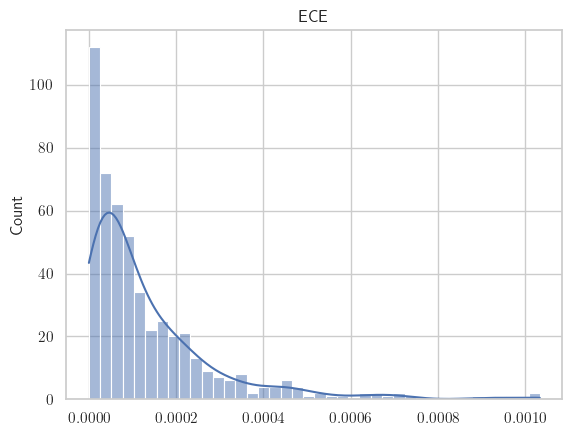

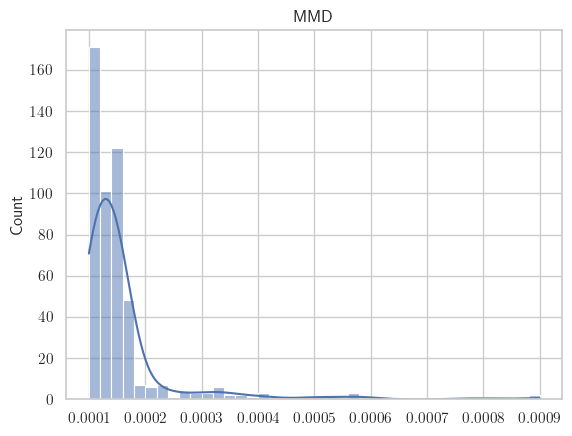

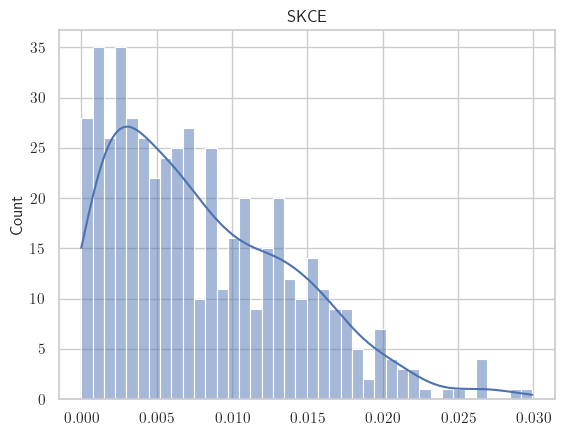

Text(0.5, 1.0, 'Brier')

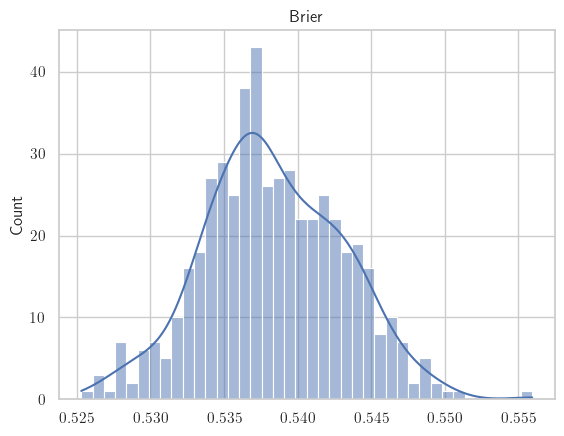

In [16]:
stats_ece = np.array(stats_ece)
sns.histplot(stats_ece, bins=40, kde=True)
plt.title("ECE")
plt.show()

stats_mmd = np.array(stats_mmd)
sns.histplot(stats_mmd, bins=40, kde=True)
plt.title("MMD")
plt.show()
stats_skce = np.array(stats_skce)
sns.histplot(stats_skce, bins=40, kde=True)
plt.title("SKCE")
plt.show()
stats_brier = np.array(stats_brier)
sns.histplot(stats_brier, bins=40, kde=True)
plt.title("Brier")


In [10]:
df_stats = pd.DataFrame({
    'ECE': stats_ece,
    'MMD': stats_mmd,
    'SKCE': stats_skce,
    'Brier': stats_brier
})

In [11]:
df_stats

,ECE,MMD,SKCE,Brier
0,0.000208,0.000123,0.021959,0.544959
1,0.000021,0.000151,0.003906,0.536094
2,0.000034,0.000143,0.000822,0.541678
3,0.000230,0.000138,0.019992,0.543008
4,0.000099,0.000106,0.009013,0.536487
...,...,...,...,...
495,0.000212,0.000127,0.002396,0.530896
496,0.000010,0.000159,0.015870,0.537370
497,0.000099,0.000107,0.017770,0.545270
498,0.000035,0.000140,0.000334,0.534166


In [12]:
for stat in ['ECE', 'MMD', 'SKCE', 'Brier']:
    print(f"{stat} contains NaN: {df_stats[stat].isnull().any()}")
    print(f"{stat} contains Inf: {np.isinf(df_stats[stat]).any()}")


ECE contains NaN: False
ECE contains Inf: False
MMD contains NaN: False
MMD contains Inf: False
SKCE contains NaN: False
SKCE contains Inf: False
Brier contains NaN: False
Brier contains Inf: False


In [13]:
plt.rcParams.update({
    "text.usetex": True,           # Use LaTeX for text rendering
    "font.family": "serif",        # Use serif fonts
    #"font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "font.size": 12,               # Default font size
    "axes.labelsize": 12,          # Axis label font size
    "axes.titlesize": 14,          # Plot title font size
    "legend.fontsize": 10,         # Legend font size
    "xtick.labelsize": 10,         # X-axis tick label font size
    "ytick.labelsize": 10,         # Y-axis tick label font size
})

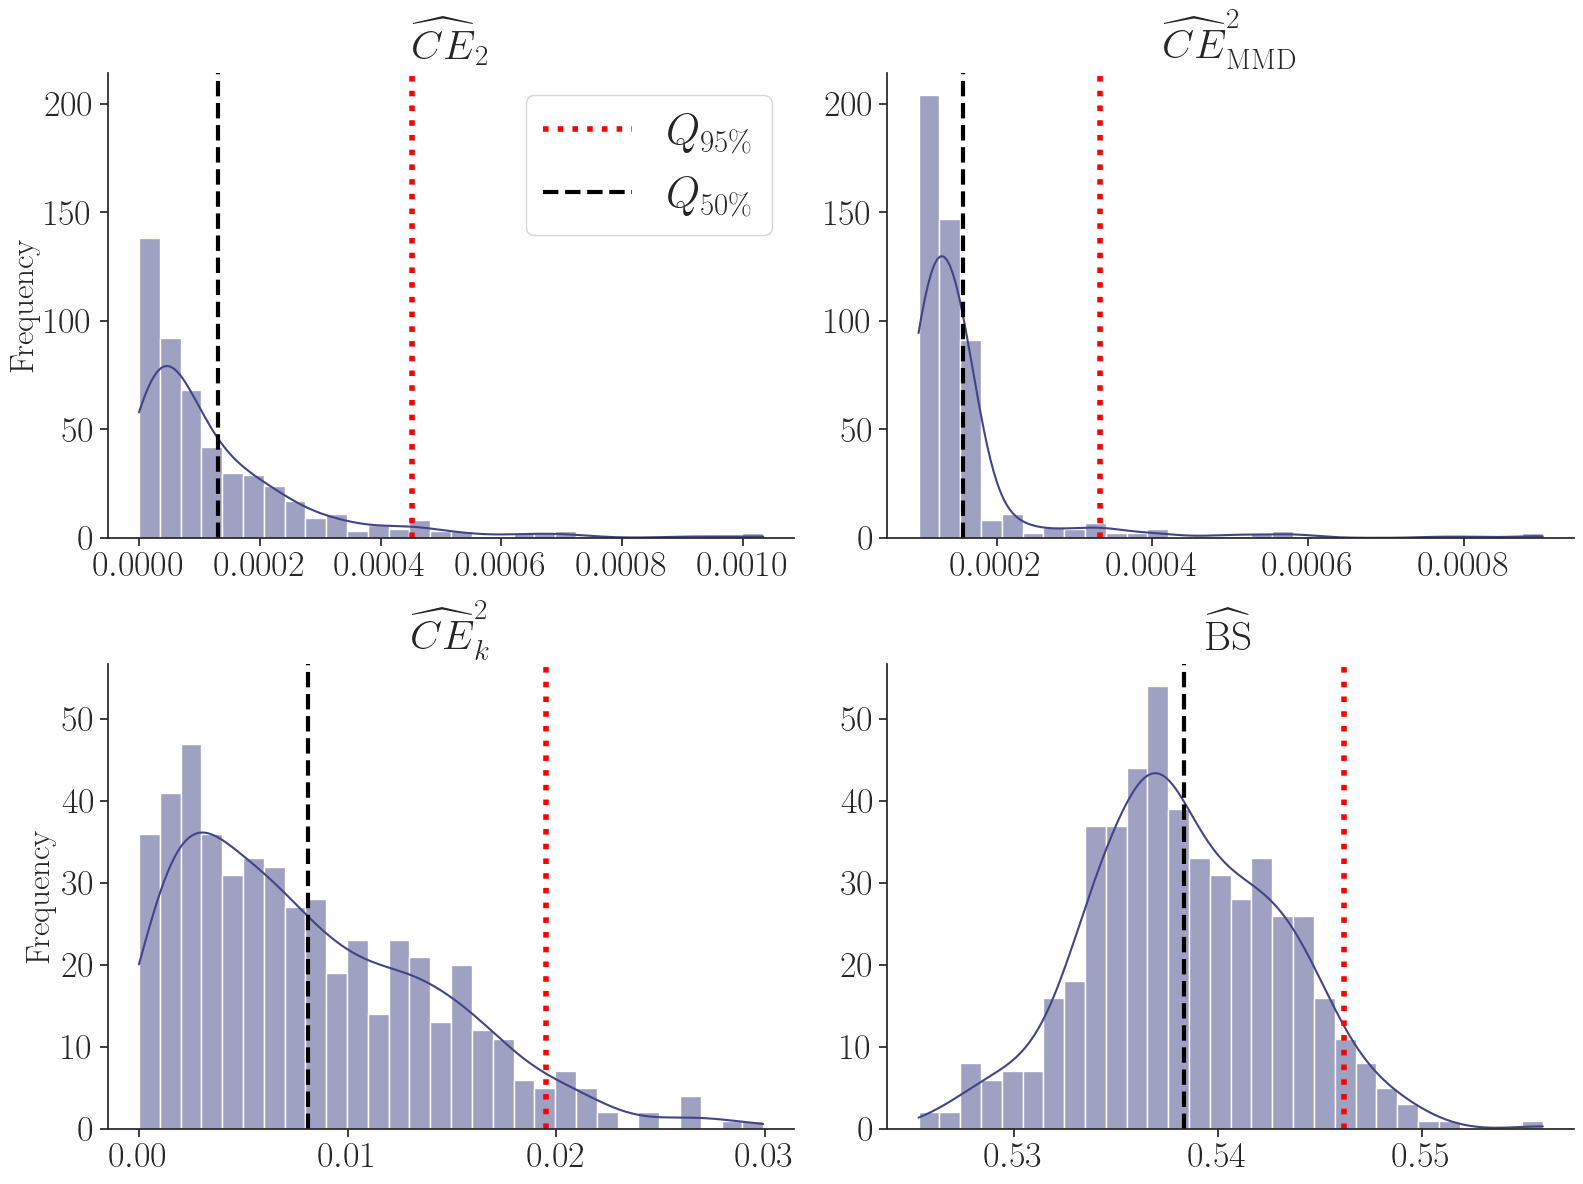

In [24]:
# Set Seaborn style
# update seaborn style: no grid, white background, and ticks on the left and bottom axes
sns.set_style("white", {"axes.grid": False, "xtick.bottom": True, "ytick.left": True})
# remove right and top spines
sns.set_style({"axes.spines.right": False, "axes.spines.top": False})

# Create subplots
fig = plt.figure(figsize=(16, 12))
# First row
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2, sharey=ax1)

# Second row
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4, sharey=ax3)

# Put axes in a list for easy iteration
axes = [ax1, ax2, ax3, ax4]

# Define the statistics and their titles
stats = ['ECE', 'MMD', 'SKCE', 'Brier']
labels = [r'$\widehat{CE}_{2}$', r'$\widehat{CE}_{\mathrm{MMD}}^2$', r'$\widehat{CE}_{k}^2$',
          r'$\widehat{\mathrm{BS}}$']
cmap = plt.get_cmap('viridis')
colors = [cmap(.2) for i in np.linspace(0, .8, len(stats))]
axes[0].set_ylabel(r'$\mathrm{Frequency}$', fontsize=26)
for i, stat in enumerate(stats):
    # Plot histogram with KDE
    sns.histplot(df_stats[stat], kde=True, ax=axes[i], color=colors[i], bins=30)
    # add quantiles 
    q_95 = np.quantile(df_stats[stat], 0.95)
    # plot vertical line at 95% quantile, using red dashed line
    axes[i].axvline(q_95, color='red', linestyle=':', linewidth=4, label=r'$Q_{95\%}$')
    
    # Calculate mean value
    mean_value = np.mean(df_stats[stat])
    
    # Add vertical line at the mean value
    axes[i].axvline(mean_value, color='black', linestyle='--', linewidth=3, label=r'$Q_{50\%}$')
    
    # Set the title and labels using LaTeX-formatted strings
    axes[i].set_title(f'{labels[i]}', fontsize=30, pad=10)
    axes[i].set_xlabel('', fontsize=20)
    if i == 0 or i == 2:
        axes[i].set_ylabel(r'$\mathrm{Frequency}$', fontsize=24)
    else:
        axes[i].set_ylabel('')
    # axes[i].set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
    
    # Adjust tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=26)
    
    # Set x-axis limits if necessary
    #axes[i].set_xlim(left=0)  # Assuming the statistics are non-negative
    
    # Add legend
axes[0].legend(fontsize=32)

# Adjust layout to prevent overlap
plt.tight_layout()
# create directory if it does not exist
os.makedirs("../figures", exist_ok=True)
plt.savefig("../figures/histogram_cal_estimates.pdf", dpi=400)


#### Visualization of simplices

/Users/mirajuergens/opt/miniconda3/envs/calibration_2/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


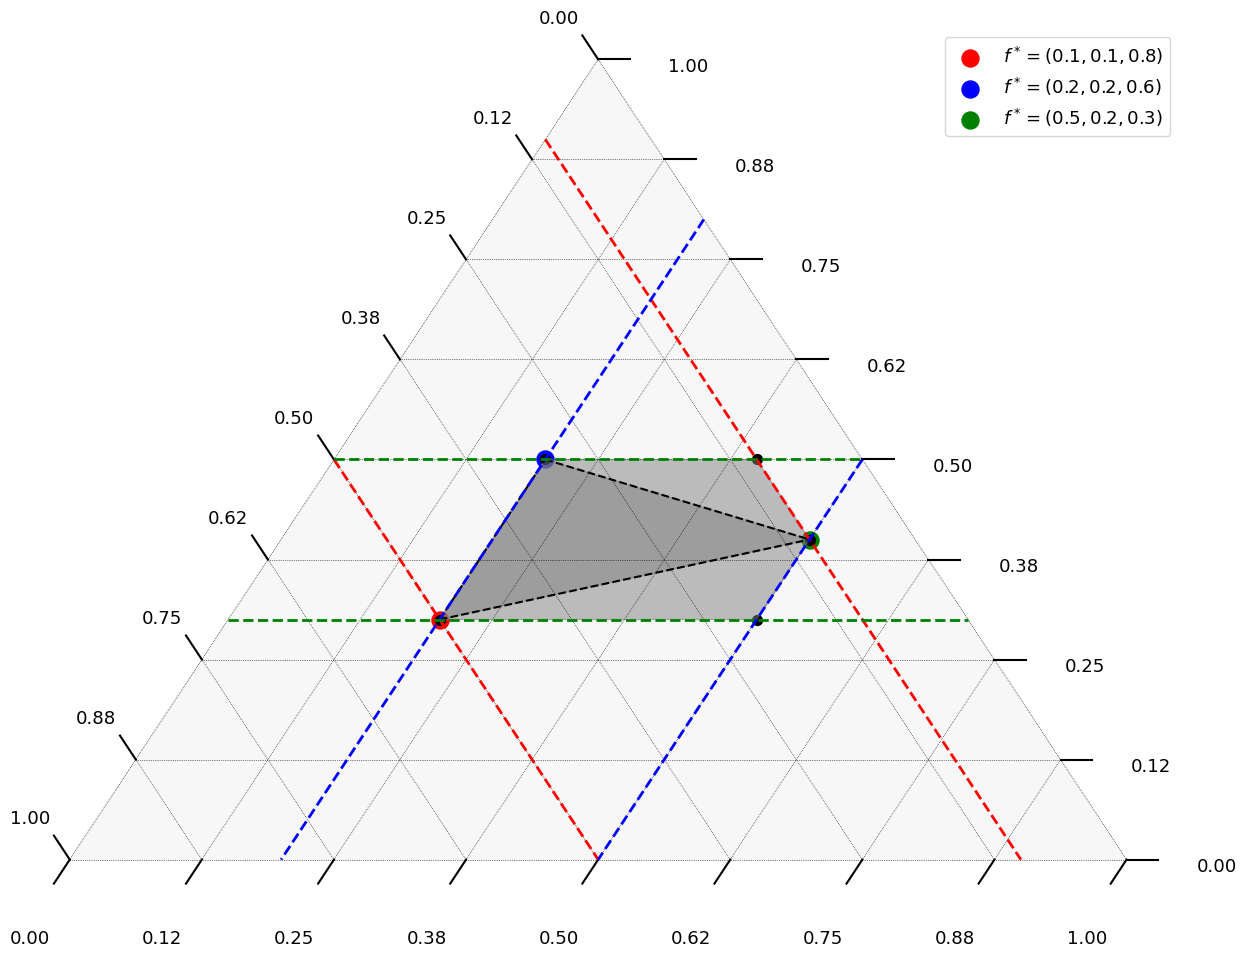

In [108]:
fig, ax = plt.subplots(figsize=(15, 12))

tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
tax.gridlines(multiple=5, color="black")

tick_multiple = 5  # Spacing between ticks in grid units
tick_values = np.arange(0, scale+1, tick_multiple)  # Tick positions
tick_labels = [f"{i/scale:.1f}" for i in tick_values]  # Normalized tick labels

point1 = (2/10 * scale, 3/10 * scale, 5/10 * scale)
point2 = (2/10 * scale, 5/10 * scale, 3/10 * scale)
point3 = (5/10 * scale, 4/10 * scale, 1/10 * scale)

# Plot the point in the simplex with a large marker size
tax.scatter([point1], marker='o', color='red', s=150, label="$f^* = (0.1, 0.1, 0.8)$")
tax.scatter([point2], marker='o', color='blue', s=150, label="$f^* = (0.2, 0.2, 0.6)$")
tax.scatter([point3], marker='o', color='green', s=150, label="$f^* = (0.5, 0.2, 0.3)$")

#draw line connecting the points
tax.line(point1, point2, color='black', linestyle='--')
tax.line(point1, point3, color='black', linestyle='--')
tax.line(point2, point3, color='black', linestyle='--')
# fill the triangle spanned by the points
cartesian_vertices = [project_point(v,) for v in [point1, point2, point3]]
x_coords, y_coords = zip(*cartesian_vertices)
tax.ax.fill(x_coords, y_coords, color='grey', alpha=0.5)

tax.set_axis_limits({'b': [0, 1], 'l': [0, 1], 'r': [0, 1]})
tax.get_ticks_from_axis_limits(multiple=tick_multiple)
tax.set_custom_ticks(tick_formats="%.2f", offset=0.03, fontsize=13)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.legend(fontsize=13)

# level line at .5 for third class
tax.right_parallel_line(0.5*scale, color='red', linestyle='--', linewidth=2)
tax.right_parallel_line(0.1*scale, color='red', linestyle='--', linewidth=2)

tax.left_parallel_line(0.5*scale, color='blue', linestyle='--', linewidth=2)
tax.left_parallel_line(0.2*scale, color='blue', linestyle='--', linewidth=2)

tax.horizontal_line(0.5*scale, color='green', linestyle='--', linewidth=2)
tax.horizontal_line(0.3*scale, color='green', linestyle='--', linewidth=2)

# # level line at .5 for second class
# # shade inner polygon spanned by the lines

vertices = [
    (0.2 * scale, 0.3 * scale, 0.5 * scale), 
    (0.2 * scale, 0.5 * scale, 0.3 * scale),
    (0.4 * scale, 0.5 * scale, 0.1 * scale),  # Intersection of a=0.5, c=0.2
    (0.5 * scale, 0.4 * scale, 0.1 * scale),  # Intersection of a=0.3, c=0.2
    (0.5*scale, 0.3*scale, 0.2*scale),  # Intersection of a=0.3, b=0.2
]

# plot vertices
tax.scatter(vertices, marker='o', color='black', s=50)

# Convert ternary coordinates to Cartesian coordinates
cartesian_vertices = [project_point(v,) for v in vertices]

# Unzip the list of points into x and y coordinates
x_coords, y_coords = zip(*cartesian_vertices)

# Fill the polygon using Matplotlib's fill method
tax.ax.fill(x_coords, y_coords, color='grey', alpha=0.5)

# save
plt.savefig("../figures/simplex_example_level_lines.png", dpi=400)

